# MCMC Fussing

In [16]:
import os
from importlib import resources

import numpy as np

import matplotlib.pyplot as plt

import emcee

import torch

from oceancolor.remote.nn import SimpleNet
from oceancolor.remote import io as remote_io

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load data

In [3]:
ab, Rs = remote_io.load_loisel_2023_pca()

# Load NN

In [37]:
#model_file = os.path.join(resources.files('oceancolor'), 'remote', 'model_100.pth')
model_file = os.path.join(resources.files('oceancolor'), 'remote', 'model_20000.pth')
model = torch.load(model_file)

In [38]:
model

SimpleNet(
  (fc1): Linear(in_features=6, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=81, bias=True)
  (fc2b): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=81, bias=True)
)

In [39]:
model.ab_parm

(array([ 2.08096449e+00,  3.35454145e+00, -1.11057161e+00, -9.55170578e-08,
        -7.59786187e-08, -1.97944187e-08]),
 array([0.2783498 , 0.26010558, 0.07432061, 0.73464354, 0.09643113,
        0.01878721]))

# Probability

In [65]:
def log_prob(ab, Rs, model, device):
    #ab_norm = (ab - model.ab_parm[0]) / model.ab_parm[1]
    #pred = model.prediction(ab_norm, device)
    pred = model.prediction(ab, device)
    #
    sig = 0.05 * Rs
    #
    return 0.5 * np.sum( (pred-Rs)**2 / sig**2)

# Random Walkers

In [41]:
ndim = model.ninput
nwalkers = 32
p0 = np.random.rand(nwalkers, ndim)

# Target

In [42]:
idx = 200
means = Rs[idx]
means

array([2.9911e-03, 3.1619e-03, 3.3126e-03, 3.4136e-03, 3.5734e-03,
       3.6922e-03, 3.7773e-03, 3.9994e-03, 4.0598e-03, 4.2426e-03,
       4.1596e-03, 4.2443e-03, 4.3370e-03, 4.4459e-03, 4.5436e-03,
       4.6101e-03, 4.6944e-03, 4.6518e-03, 4.5565e-03, 4.4649e-03,
       4.3524e-03, 4.3817e-03, 4.4984e-03, 4.6112e-03, 4.6439e-03,
       4.6186e-03, 4.4849e-03, 4.3980e-03, 4.2135e-03, 3.9199e-03,
       3.6235e-03, 3.1635e-03, 2.6997e-03, 2.3472e-03, 2.2645e-03,
       2.2066e-03, 2.1013e-03, 2.0034e-03, 1.8958e-03, 1.7414e-03,
       1.5697e-03, 1.4651e-03, 1.3896e-03, 1.3167e-03, 1.1993e-03,
       1.0574e-03, 8.9690e-04, 7.2372e-04, 5.9155e-04, 4.6866e-04,
       3.4712e-04, 2.9184e-04, 2.7758e-04, 2.6786e-04, 2.5178e-04,
       2.3948e-04, 2.2719e-04, 2.1523e-04, 2.0450e-04, 1.9285e-04,
       1.8139e-04, 1.6482e-04, 1.4628e-04, 1.4112e-04, 1.4358e-04,
       1.5056e-04, 1.5518e-04, 1.5736e-04, 1.4550e-04, 1.2064e-04,
       9.6823e-05, 7.7407e-05, 6.1742e-05, 4.9557e-05, 4.0445e

In [56]:
ab[idx]

array([ 2.09002280e+00,  3.30304408e+00, -1.17998254e+00, -2.11087331e-01,
        5.14956564e-03,  9.47382825e-04])

In [66]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[means, model, device])

# Burn in

In [67]:
state = sampler.run_mcmc(p0, 100)
sampler.reset()

In [68]:
p0[0]

array([0.91106486, 0.29238987, 0.13402843, 0.13623739, 0.92272885,
       0.53192527])

# Run

In [69]:
sampler.run_mcmc(state, 10000);

/tmp/ipykernel_968516/3182884355.py:8: RuntimeWarning: overflow encountered in divide
  return 0.5 * np.sum( (pred-Rs)**2 / sig**2)


In [70]:
samples = sampler.get_chain(flat=True)

In [71]:
samples.shape

(320000, 6)

In [78]:
samples[-1,:]

array([ 4.17486374e+15, -2.65438210e+15,  5.91823870e+15,  2.29814365e+16,
       -1.54161489e+16,  1.95807828e+16])

# Plot

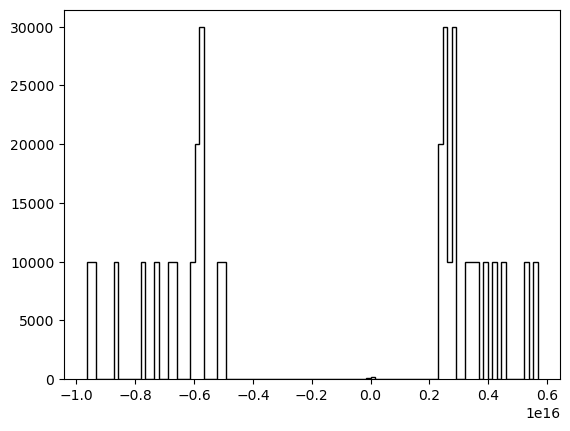

In [73]:
plt.clf()
plt.hist(samples[:,0], 100, color='k', histtype='step')
#
plt.show()

----

In [77]:
samples[:,-1].shape

(320000,)

In [75]:
pred = model.prediction(samples[:,-1], device)

ValueError: operands could not be broadcast together with shapes (320000,) (6,) 

In [62]:
pred = model.prediction(ab[idx], device)
pred

array([2.7662888e-03, 2.9148874e-03, 3.1095059e-03, 3.2807994e-03,
       3.4793075e-03, 3.6345324e-03, 3.8075321e-03, 4.2071999e-03,
       4.2475709e-03, 4.3116277e-03, 4.3672975e-03, 4.3981508e-03,
       4.6101152e-03, 4.7363145e-03, 4.9556545e-03, 5.0201593e-03,
       4.9696993e-03, 4.9452782e-03, 4.8327963e-03, 4.7496040e-03,
       4.5772241e-03, 4.5990199e-03, 4.7164117e-03, 4.7902218e-03,
       4.7043664e-03, 4.7598151e-03, 4.5940895e-03, 4.5192931e-03,
       4.3631233e-03, 4.1075298e-03, 3.7774225e-03, 3.3359034e-03,
       2.8534126e-03, 2.4767679e-03, 2.3943624e-03, 2.3368045e-03,
       2.2400504e-03, 2.1517875e-03, 2.0384933e-03, 1.8627306e-03,
       1.6717898e-03, 1.5682479e-03, 1.5053246e-03, 1.4153229e-03,
       1.2821828e-03, 1.1473484e-03, 9.7208802e-04, 7.8203535e-04,
       6.3114212e-04, 5.0090143e-04, 3.7118566e-04, 3.0890590e-04,
       2.9425047e-04, 2.8834958e-04, 2.7163781e-04, 2.5169531e-04,
       2.4110237e-04, 2.2814394e-04, 2.1956247e-04, 2.0556622e

In [63]:
log_prob(ab[idx], means, model, device)

NameError: name 'ab_norm' is not defined

In [51]:
(pred-means)/pred

array([-0.08126818, -0.08474173, -0.06531398, -0.04047811, -0.02704344,
       -0.01586655,  0.00794008,  0.04939151,  0.04420666,  0.01600968,
        0.04755744,  0.03498079,  0.05924255,  0.06131652,  0.08314832,
        0.08168256,  0.05539559,  0.05934517,  0.05717112,  0.05994266,
        0.04911799,  0.04725353,  0.0462241 ,  0.0373723 ,  0.01285329,
        0.02966818,  0.02376742,  0.02683896,  0.03429275,  0.04567948,
        0.04074802,  0.05168118,  0.05386977,  0.05231331,  0.05423676,
        0.05571903,  0.06194071,  0.06896017,  0.06999939,  0.06513589,
        0.06106619,  0.06577272,  0.07687686,  0.06968224,  0.06464188,
        0.07839677,  0.07734691,  0.07456868,  0.06273087,  0.06436681,
        0.06483458,  0.05524629,  0.05665401,  0.07105806,  0.07310398,
        0.04853215,  0.05770318,  0.05660434,  0.0686022 ,  0.06185948,
        0.06580777,  0.06256645,  0.06685673,  0.09807864,  0.10190737,
        0.10018446,  0.10776525,  0.11778813,  0.14843091,  0.10